# Generative Adversarial Network

In this notebook, we'll be building a generative adversarial network (GAN) trained on the MNIST dataset. From this, we'll be able to generate new handwritten digits!

GANs were [first reported on](https://arxiv.org/abs/1406.2661) in 2014 from Ian Goodfellow and others in Yoshua Bengio's lab. Since then, GANs have exploded in popularity. Here are a few examples to check out:

* [Pix2Pix](https://affinelayer.com/pixsrv/) 
* [CycleGAN & Pix2Pix in PyTorch, Jun-Yan Zhu](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix)
* [A list of generative models](https://github.com/wiseodd/generative-models)

The idea behind GANs is that you have two networks, a generator $G$ and a discriminator $D$, competing against each other. The generator makes "fake" data to pass to the discriminator. The discriminator also sees real training data and predicts if the data it's received is real or fake. 
> * The generator is trained to fool the discriminator, it wants to output data that looks _as close as possible_ to real, training data. 
* The discriminator is a classifier that is trained to figure out which data is real and which is fake. 

What ends up happening is that the generator learns to make data that is indistinguishable from real data to the discriminator.

<img src='assets/gan_pipeline.png' width=70% />

The general structure of a GAN is shown in the diagram above, using MNIST images as data. The latent sample is a random vector that the generator uses to construct its fake images. This is often called a **latent vector** and that vector space is called **latent space**. As the generator trains, it figures out how to map latent vectors to recognizable images that can fool the discriminator.

If you're interested in generating only new images, you can throw out the discriminator after training. In this notebook, I'll show you how to define and train these adversarial networks in PyTorch and generate new images!

In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
!wget -O MNIST.tar.gz https://activeeon-public.s3.eu-west-2.amazonaws.com/datasets/MNIST.old.tar.gz

--2021-03-25 09:44:59--  https://activeeon-public.s3.eu-west-2.amazonaws.com/datasets/MNIST.old.tar.gz
Resolving activeeon-public.s3.eu-west-2.amazonaws.com (activeeon-public.s3.eu-west-2.amazonaws.com)... 52.95.148.30
Connecting to activeeon-public.s3.eu-west-2.amazonaws.com (activeeon-public.s3.eu-west-2.amazonaws.com)|52.95.148.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23212732 (22M) [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz        100%[===================>]  22.14M  16.4MB/s    in 1.3s    

2021-03-25 09:45:01 (16.4 MB/s) - ‘MNIST.tar.gz’ saved [23212732/23212732]



In [3]:
!tar -zxvf MNIST.tar.gz

MNIST/
MNIST/raw/
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/processed/
MNIST/processed/test.pt
MNIST/processed/training.pt


In [4]:
!mv MNIST/processed .
!mv MNIST/raw .

mv: cannot move 'MNIST/processed' to './processed': Directory not empty
mv: cannot move 'MNIST/raw' to './raw': Directory not empty


In [5]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# get the training datasets
#train_data = datasets.MNIST(root='data', train=True,
                                   # download=False, transform=transform)
train_data = datasets.MNIST('./', download=False, train=True, transform=transform)
# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)

### Visualize the data

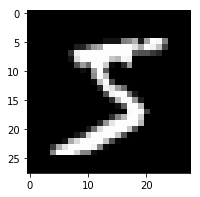

In [6]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

The discriminator network is going to be a pretty typical linear classifier. To make this network a universal function approximator, we'll need at least one hidden layer, and these hidden layers should have one key attribute:
> All hidden layers will have a [Leaky ReLu](https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU) activation function applied to their outputs.

<img src='assets/gan_network.png' width=70% />

#### Leaky ReLu

We should use a leaky ReLU to allow gradients to flow backwards through the layer unimpeded. A leaky ReLU is like a normal ReLU, except that there is a small non-zero output for negative input values.

<img src='assets/leaky_relu.png' width=40% />

#### Sigmoid Output

We'll also take the approach of using a more numerically stable loss function on the outputs. Recall that we want the discriminator to output a value 0-1 indicating whether an image is _real or fake_. 
> We will ultimately use [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss), which combines a `sigmoid` activation function **and** and binary cross entropy loss in one function. 

So, our final output layer should not have any activation function applied to it.

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # define all layers
        # input_size:number of flattened pixels in an input image
        # hidden_dim: output size of final hidden layer (*2 for more than one hidden layers)
        # output_size: in this case, this is just a single value indicated whether an input image is likely fake or real
        
        # define 3 hidden linear layers （here we use the hidden layers which are also fully-connected layers）
        self.fc1 = nn.Linear(input_size, hidden_dim*4) # first layer (784 -> 128)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2) # second layer (128 -> 64)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim) # third layer (64 -> 32)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size) # (32 -> 1)
        
        # dropout layer(apply the dropout layer in between each of my linear)
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        # flatten image into a vector shape
        x = x.view(-1, 28*28)
        # pass x through all layers
        # apply leaky relu activation to all hidden layers
        # A leaky ReLU is like a normal ReLU, except that there is a small non-zero output for negative input values.
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope = 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        
        # final layer (we don't need apply activation function here)
        # We will ultimately use BCEWithLogitsLoss, which combines a sigmoid activation function and and 
        # binary cross entropy loss in one function.
        # So, our final output layer should not have any activation function applied to it.
        out = self.fc4(x)
        

        return out


## Generator

The generator network will be almost exactly the same as the discriminator network, except that we're applying a [tanh activation function](https://pytorch.org/docs/stable/nn.html#tanh) to our output layer.

#### tanh Output
The generator has been found to perform the best with $tanh$ for the generator output, which scales the output to be between -1 and 1, instead of 0 and 1. 

<img src='assets/tanh_fn.png' width=40% />

Recall that we also want these outputs to be comparable to the *real* input pixel values, which are read in as normalized values between 0 and 1. 
> So, we'll also have to **scale our real input images to have pixel values between -1 and 1** when we train the discriminator. 

I'll do this in the training loop, later on.

In [8]:
class Generator(nn.Module): ### take in a latent vector z and produce an image as output

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define all layers
        # define 3 hidden linear layers （here we use the hidden layers which are also fully-connected layers）
        ### here the output of the each successive layer is getting larger than smaller ###
        self.fc1 = nn.Linear(input_size, hidden_dim) # first layer (100 -> 32)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2) # second layer (32 -> 64)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4) # third layer (64 -> 128)
        
        # final fully-connected layer
        ### output vector can be reshaped into a new image, output_size = 28*28
        self.fc4 = nn.Linear(hidden_dim*4, output_size) # (128 -> 28*28)
        
        # dropout layer(apply the dropout layer in between each of my linear)
        self.dropout = nn.Dropout(0.3)
        

    def forward(self, x): ### x is a latent vector so we don't need to perform a flattening step
        # pass x through all layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope = 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer should have tanh applied
        # we apply tanh activation function will scale the output of this layer to be the values between -1 and 1
        out = F.tanh(self.fc4(x))
        
        return out

## Model hyperparameters

In [9]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of *last* hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector z to give to generator (we can choose any size)
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of *first* hidden layer in the generator
g_hidden_size = 32

## Build complete network

Now we're instantiating the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [10]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3)
)


---
## Discriminator and Generator Losses

Now we need to calculate the losses. 

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.

<img src='assets/gan_pipeline.png' width=70% />

The losses will by binary cross entropy loss with logits, which we can get with [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss). This combines a `sigmoid` activation function **and** and binary cross entropy loss in one function.

For the real images, we want `D(real_images) = 1`. That is, we want the discriminator to classify the the real images with a label = 1, indicating that these are real. To help the discriminator generalize better, the labels are **reduced a bit from 1.0 to 0.9**. For this, we'll use the parameter `smooth`; if True, then we should smooth our labels. In PyTorch, this looks like `labels = torch.ones(size) * 0.9`

The discriminator loss for the fake data is similar. We want `D(fake_images) = 0`, where the fake images are the _generator output_, `fake_images = G(z)`. 

### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get `D(fake_images) = 1`. In this case, the labels are **flipped** to represent that the generator is trying to fool the discriminator into thinking that the images it generates (fakes) are real!

In [14]:
# Calculate losses
def real_loss(D_out, smooth=False): 
    #### when we train, there will be one output value for each input image (real image) in a batch #####
    # D_out is the logits or outputs from the discriminator
    # we compare discriminator output logits to the real labels
    # smooth labels if smooth=True (this can make the discriminator numerically stable and to help it generalize better )
    ### we use BCEWithLogitsLoss (binary cross entropy loss) which is well suited for just two classes tasks
    ### (real or fake images) to compare the  disriminator output to the real labels
    ### BCELoss is just normal cross entropy loss but applied to caseswith two classes !!!
    ### BCEWithLogitsLoss = sigmoid layer + BCELoss
    
    batch_size = D_out.size(0) # how many output values 
    # label smoothing:
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9 # creat a series of one labels and multiply all of those by 0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    # define loss criterion, numerically stable loss
    criterion = nn.BCEWithLogitsLoss() ### including a Sigmoid function to D_out logits!!!
    # calculate loss：compare discriminator output logits to the real labels
    loss = criterion(D_out.squeeze(), labels) # squeeze any empty dimensions from the outputs
    return loss # returns calculated binary cross entropy loss

def fake_loss(D_out):
    #### when we train, there will be one output value for each input image (fake image) in a batch #####
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # compare discriminator output logits to fake labels
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

We want to update the generator and discriminator variables separately. So, we'll define two separate Adam optimizers.

In [23]:
import torch.optim as optim

# learning rate for optimizers
lr = 0.002

# Create optimizers for the discriminator and generator, and we will train the two models separately
d_optimizer = optim.Adam(D.parameters(), lr) # passing the parameters for the discriminator
g_optimizer = optim.Adam(G.parameters(), lr) # passing the parameters for the generator

---
## Training

Training will involve alternating between training the discriminator and the generator. We'll use our functions `real_loss` and `fake_loss` to help us calculate the discriminator losses in all of the following cases.

### Discriminator training
1. Compute the discriminator loss on real, training images        
2. Generate fake images
3. Compute the discriminator loss on fake, generated images     
4. Add up real and fake loss
5. Perform backpropagation + an optimization step to update the discriminator's weights

### Generator training
1. Generate fake images
2. Compute the discriminator loss on fake images, using **flipped** labels!
3. Perform backpropagation + an optimization step to update the generator's weights

#### Saving Samples

As we train, we'll also print out some loss statistics and save some generated "fake" samples.

In [24]:
import pickle as pkl

# training hyperparams
num_epochs = 40

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
### created this fixed data above the training loop for comparison purposes how our samples change over time
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    ### for i, data in enumerate(train_loader) ###
    ### inputs, labels = data ###
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        ## The reason is our generator output have been scaled to be values between -1 and 1 with a tanh function, so we 
        ## want the "real_images" is to be comparable to these real pixel values
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
                
        # 1. Train with real images
        
        # zero out any accumulated gradients
        d_optimizer.zero_grad()
        # Compute the discriminator losses on real images
        ### use smoothed labels to make sure to smooth these labels so that the loss are numerically stable and my generator 
        ### will generalize better
        ### the discriminator wants D_real (logits) to be close to one, so we are calculating the loss to see
        ### how close these are to be in true labels
        D_real = D(real_images) # D_real: logits 
        d_real_loss = real_loss(D_real, smooth = True)
        # 2. Train with fake images
        
        # Generate fake images
        ### step 1: generating a latent vector z using values taken from a uniform distribution with values between (-1, 1)
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        ### step 2: converting these to be float tensors that can be passed to a generator
        z = torch.from_numpy(z).float()
        ### step 3: generator G can take this as input and generate some fake image vectors as output
        ### the generator outputs 784-length vector for each fake image in a batch 
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images   
        ### passing the fake images to the discriminator
        D_fake = D(fake_images) # D_fake: logits
        ### discriminator want these outputs to be close to zero, so we are calculating the the fake loss to see
        ### close these outputs are to zero 
        d_fake_loss = fake_loss(D_fake)
        
        # add up real and fake losses and perform backprop and optimization
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step() ### use d_optimizer to update my discriminator's weights
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        ### we will see how the discriminator performs when it sees generated fake images
        g_optimizer.zero_grad()
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        ### step 1: generating a latent vector z using values taken from a uniform distribution with values between (-1, 1)
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        ### step 2: converting these to be float tensors that can be passed to a generator
        z = torch.from_numpy(z).float()
        ### step 3: generator G can take this as input and generate some fake image vectors as output
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using real loss to flip labels!
        D_fake = D(fake_images) ## D_fake: logits
        g_loss = real_loss(D_fake) ### this is our adversarial loss,the genrator wants these outputs to be as close to one
                                   ### or real as possible. So we use real_loss to see how close these output are to the label
                                   ### one.
                                   ### This gives us the total generator loss and we can use this for 
                                   ### backpropagation and g_optimization
                    #### The generator loss will look similar only with flipped labels. The generator's goal ####
                    #### is to get D(fake_images) = 1. In this case, the labels are flipped to represent that ####
                    #### the generator is trying to fool the discriminator into thinking that the images it ####
                    #### generates (fakes) are real! ####
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()
        

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    ### the Generator should be set to eval mode for sample generation ###
    ### this is to account for the different behavior that a dropout layer has during training vs during model evaluation ###
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z) # save some generated samples
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f) #### we use library "pkl" to save these samples

Epoch [    1/   40] | d_loss: 2.6726 | g_loss: 0.2303
Epoch [    1/   40] | d_loss: 1.0694 | g_loss: 1.3207
Epoch [    1/   40] | d_loss: 0.7032 | g_loss: 3.4448
Epoch [    2/   40] | d_loss: 1.3553 | g_loss: 0.8216
Epoch [    2/   40] | d_loss: 1.3963 | g_loss: 1.0176
Epoch [    2/   40] | d_loss: 1.4624 | g_loss: 0.8558
Epoch [    3/   40] | d_loss: 1.3978 | g_loss: 0.8533
Epoch [    3/   40] | d_loss: 1.2694 | g_loss: 0.9023
Epoch [    3/   40] | d_loss: 1.5296 | g_loss: 0.7093
Epoch [    4/   40] | d_loss: 1.2756 | g_loss: 1.0641
Epoch [    4/   40] | d_loss: 1.6320 | g_loss: 1.0253
Epoch [    4/   40] | d_loss: 1.2841 | g_loss: 1.5642
Epoch [    5/   40] | d_loss: 1.1336 | g_loss: 1.1395
Epoch [    5/   40] | d_loss: 1.1581 | g_loss: 1.5324
Epoch [    5/   40] | d_loss: 1.7648 | g_loss: 1.2779
Epoch [    6/   40] | d_loss: 1.2959 | g_loss: 1.5062
Epoch [    6/   40] | d_loss: 1.3904 | g_loss: 1.2247
Epoch [    6/   40] | d_loss: 1.2719 | g_loss: 1.1535
Epoch [    7/   40] | d_loss

## Training loss

Here we'll plot the training losses for the generator and discriminator, recorded after each epoch.

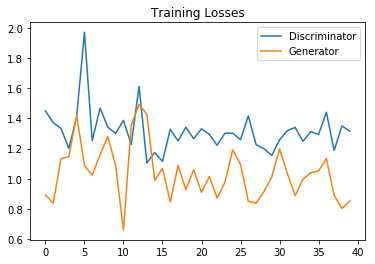

In [25]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Generator samples from training

Here we can view samples of images from the generator. First we'll look at the images we saved during training.

In [26]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples): # take in a list of sample fake image vectors and display some of them 
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [27]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

These are samples from the final training epoch. You can see the generator is able to reproduce numbers like 1, 7, 3, 2. Since this is just a sample, it isn't representative of the full range of images this generator can make.

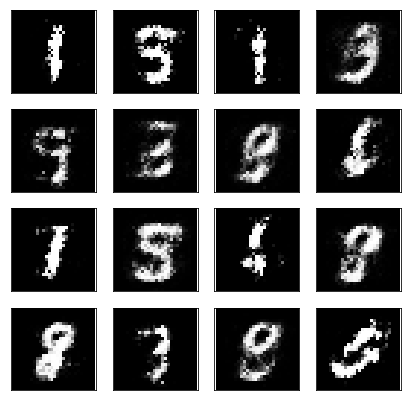

In [28]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

Below I'm showing the generated images as the network was training, every 10 epochs.

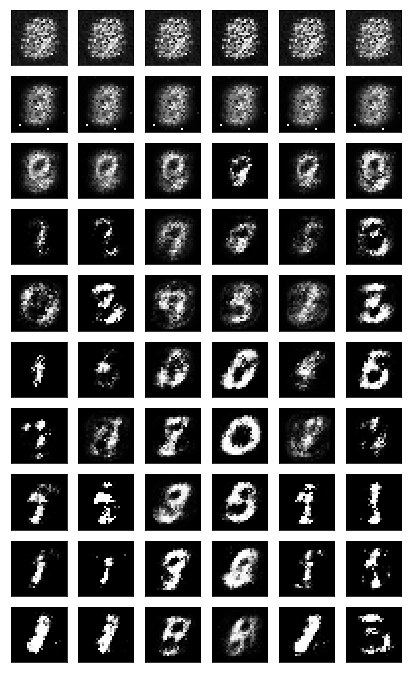

In [29]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

It starts out as all noise. Then it learns to make only the center white and the rest black. You can start to see some number like structures appear out of the noise like 1s and 9s.

## Sampling from the generator

We can also get completely new images from the generator by using the checkpoint we saved after training. **We just need to pass in a new latent vector $z$ and we'll get new samples**!

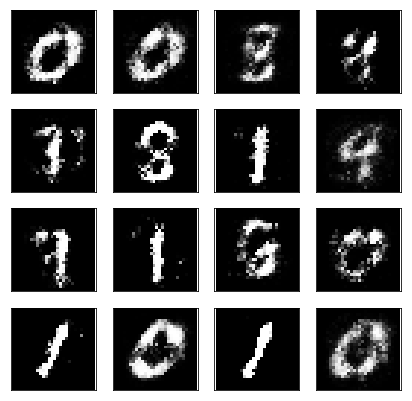

In [30]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode cause it's no longer training
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only get one batch of samples, here
view_samples(0, [rand_images])